In [1]:
%matplotlib widget

import pathlib

import fifteen
import jax
import jax_dataclasses as jdc
import numpy as onp
from jax import numpy as jnp

import tensorf.data
import tensorf.render
import tensorf.train_config
import tensorf.training

import matplotlib.pyplot as plt

In [2]:
# Load experiment.
run_dir = pathlib.Path("./runs/lego-2022-04-15-08:49:53/")
experiment = fifteen.experiments.Experiment(data_dir=run_dir)
config = experiment.read_metadata("config", tensorf.train_config.TensorfConfig)

[Experiment] Reading metadata from runs/lego-2022-04-15-08:49:53/config.yaml


In [3]:
# Load the training state from a checkpoint.
train_state = tensorf.training.TrainState.initialize(
    config=config,
    grid_dim=config.grid_dim_final,
    prng_key=jax.random.PRNGKey(0),
)
train_state = experiment.restore_checkpoint(train_state)
assert train_state.step > 0

# Load the training dataset... we're only going to use this to grab a camera.
train_views = tensorf.data.load_blender_dataset(
    dataset_root=config.dataset_path, split="train", progress_bar=True
)
camera = train_views[5].camera

[Experiment] Successfully loaded checkpoint!


Loading lego:   0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
# Define a rendering helper.
def render(
    mode: tensorf.render.RenderMode,
    image_width: int = 800,
    image_height: int = 800,
) -> jnp.ndarray:
    resized_camera = camera.resize_with_fixed_fov(
        image_width=image_width, image_height=image_height
    )
    return tensorf.render.render_rays_batched(
        appearance_mlp=train_state.appearance_mlp,
        learnable_params=train_state.learnable_params,
        aabb=train_state.aabb,
        rays_wrt_world=resized_camera.pixel_rays_wrt_world(),
        prng_key=jax.random.PRNGKey(0),
        config=tensorf.render.RenderConfig(
            near=0.1,
            far=10.0,
            mode=mode,
            density_samples_per_ray=256,
            appearance_samples_per_ray=32,
        ),
        batch_size=32000,
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
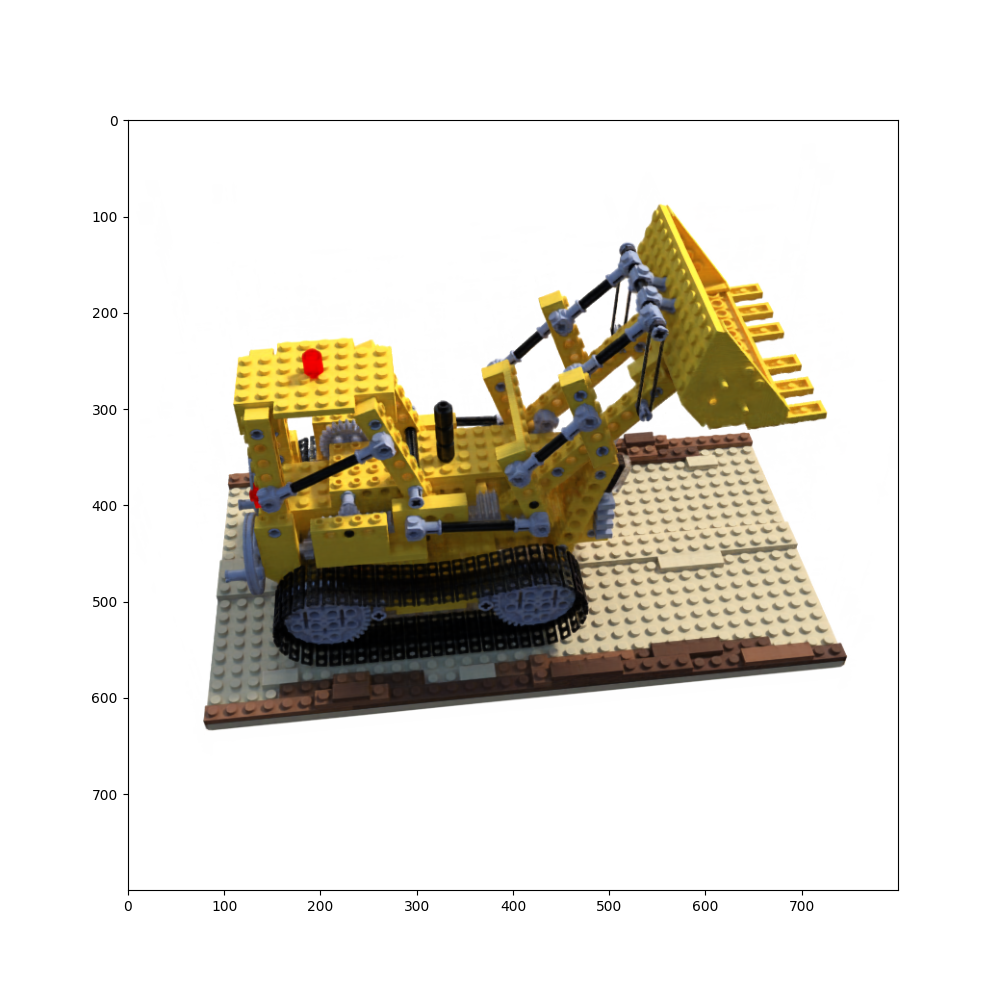

In [10]:
# Render RGB.
plt.figure(figsize=(10, 10))
plt.imshow(render(tensorf.render.RenderMode.RGB))
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
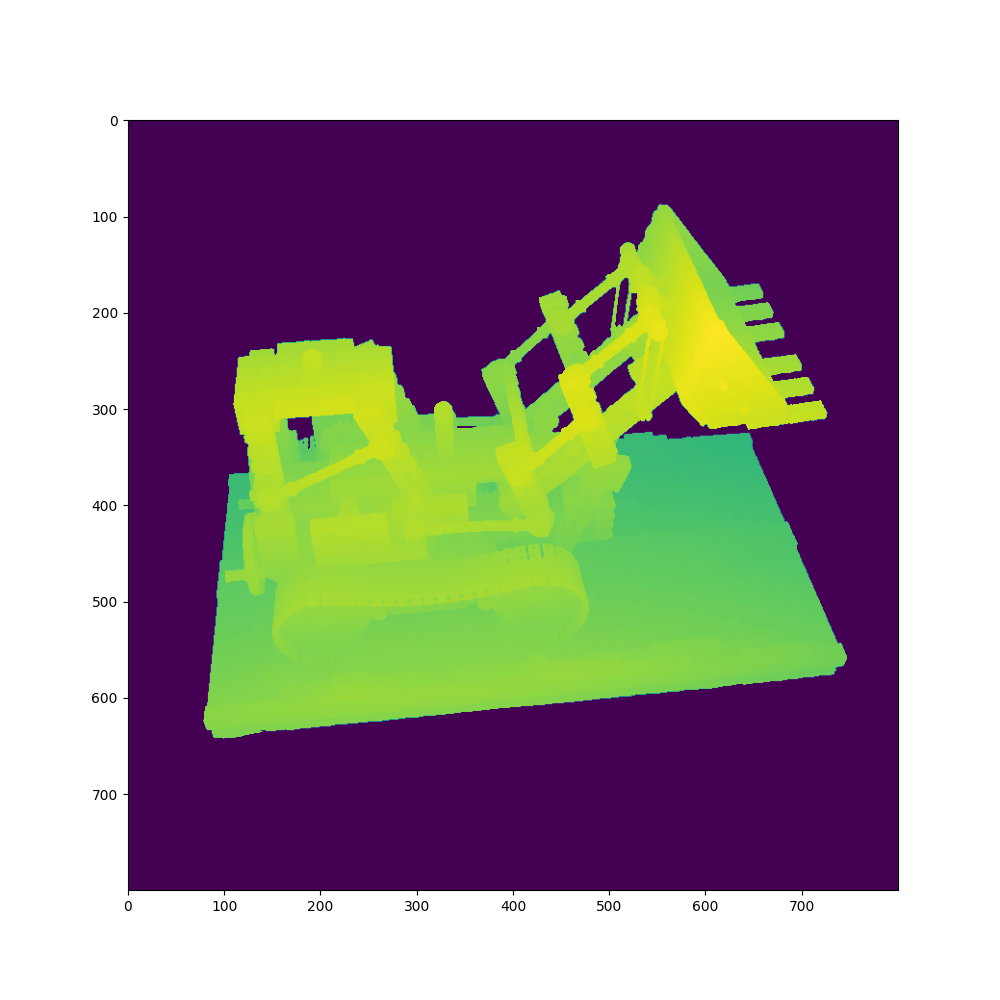

In [11]:
# Render depth / disparity.
plt.figure(figsize=(10, 10))
plt.imshow(1.0 / render(tensorf.render.RenderMode.DIST_MEDIAN))
plt.show()